In [47]:
#Imports
import numpy as np
import quimb as qb
import matplotlib.pyplot as plt
import scipy.constants as const
from scipy.integrate import solve_ivp
from scipy.linalg import logm

In [48]:
# Hamiltonian of electron spin in magnetic field
hamiltonian = np.array([[0, 1.0],[1.0, 0]])
hamiltonian = -1*const.physical_constants['Bohr magneton'][0]*hamiltonian

# Create density matrix with initial conditions
density_matrix_init  = np.array([0.9, 0, 0, 0.1]).astype(complex)

In [49]:
# Helper Functions
def commutator(matA, matB):
    return (np.matmul(matA, matB) - np.matmul(matB, matA))

def density_dot(time, density_matrix):
    # Von Neumann Contribution
    density_reshape = density_matrix.reshape((2,2))
    current_density_dot = (-1j/const.hbar)*commutator(hamiltonian, density_reshape)
    return (current_density_dot.reshape((1,-1)))

In [50]:
# Time Parameters
T_MIN = 0
T_MAX = 60e-12
# Solve the initial value problem
sol = solve_ivp(density_dot, [T_MIN, T_MAX], density_matrix_init, max_step=T_MAX/1000)

In [51]:
# Extract Pppulations
density_matrix_00 = sol.y[0]
density_matrix_11 = sol.y[3]


# Find entanglement entropy over time
entanglement_entropy = []
mutual_information   = []
for current_rho_vec in np.transpose(sol.y):
    current_rho_mat = np.array([[0,0,0,0], [0, current_rho_vec[0], current_rho_vec[1], 0],[0, current_rho_vec[2], current_rho_vec[3],0],[0,0,0,0]])
    partial_rho     = qb.ptr(current_rho_mat, [2,2], [0])
    partial_rho_b   = qb.ptr(current_rho_mat, [2,2], [1])
    current_entropy = -1*np.trace(partial_rho@logm(partial_rho))
    current_entropy_b = -1*np.trace(partial_rho_b@logm(partial_rho_b))
    total_current_entropy = -1*np.trace(current_rho_mat@logm(current_rho_mat))
    entanglement_entropy.append(current_entropy)
    mutual_information.append(current_entropy + current_entropy_b - total_current_entropy)


c:\Users\conor\anaconda3\lib\site-packages\scipy\linalg\_matfuncs_inv_ssq.py:827: LogmExactlySingularWarning: The logm input matrix is exactly singular.
  warnings.warn(exact_singularity_msg, LogmExactlySingularWarning)


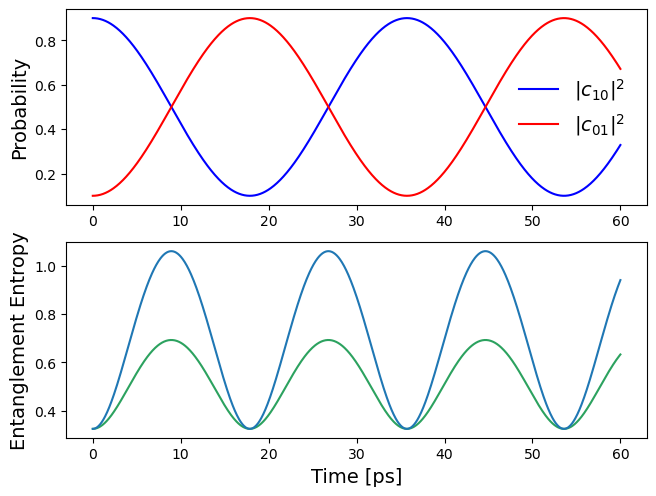

In [53]:
# Plotting
fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
ax1.plot(sol.t*1e12, density_matrix_00.real, label=r"$|c_{10}|^2$", color='b')
ax1.plot(sol.t*1e12, density_matrix_11.real, label=r"$|c_{01}|^2$", color='r')
ax2.plot(sol.t*1e12, entanglement_entropy, color="#2ca25f")
ax2.plot(sol.t*1e12, mutual_information)

fig.tight_layout(pad=1.0)

# Legend Placement
ax1.legend(fontsize=14, frameon=False, loc='center left', bbox_to_anchor=(0.75,0.5))
ax2.set_xlabel('Time [ps]', fontsize=14)
ax1.set_ylabel('Probability', fontsize=14)
ax2.set_ylabel('Entanglement Entropy', fontsize=14)

fig.patch.set_alpha(0.0)
ax1.patch.set_alpha(1.0)
ax2.patch.set_alpha(1.0)

#plt.savefig("entanglement_entropy.svg", dpi=300, bbox_inches = "tight")

plt.show()